In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import gc
import time
import numpy as np
import pandas as pd
from time import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import torch

import matplotlib.pyplot as plt

from fastai.imports import *
from fastai.structured import*
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
PATH = "/home/vishy/Desktop/Myfiles/AV/AMEX/"

In [4]:
def handle_missing_inplace(df):
    df['age_level'].fillna(value=99.0, inplace=True)
    df['city_development_index'].fillna(value=99.0, inplace=True)
    df['gender'].fillna(value='Unknown', inplace=True)
    df['product_category_2'].fillna(value=999999.0, inplace=True)
    df['user_depth'].fillna(value=99.0, inplace=True)
    df['user_group_id'].fillna(value=99.0, inplace=True)
    return df

In [5]:
def timeFeatures(df):
    # Make some new features with click_time column
    df['day'] = df['DateTime'].dt.day.astype('uint8')
    df['hour'] = df['DateTime'].dt.hour.astype('uint8')
    df['minute'] = df['DateTime'].dt.minute.astype('uint8')
    df['dow'] = df['DateTime'].dt.dayofweek.astype('uint8')
    #df.drop(['DateTime'], axis=1, inplace=True)
    return df

In [6]:
train = pd.read_csv(PATH+'train.csv', low_memory=False, parse_dates=['DateTime'])
train.rename(columns={'product':'prod'}, inplace=True)
print(train.shape)

(463291, 15)


In [7]:
test = pd.read_csv(PATH+'test.csv', low_memory=False, parse_dates=['DateTime'])
test.rename(columns={'product':'prod'}, inplace=True)
print(test.shape)

(128858, 14)


In [8]:
test['is_click']=0

In [9]:
test.head()

,session_id,DateTime,user_id,prod,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click
0,411705,2017-07-08,732573,J,404347,53587,1,NaN,5.0,Male,5.0,3.0,NaN,0,0
1,208263,2017-07-08,172910,I,118601,28529,3,82527.0,NaN,NaN,NaN,NaN,NaN,1,0
2,239450,2017-07-08,172910,I,118601,28529,4,82527.0,NaN,NaN,NaN,NaN,NaN,1,0
3,547761,2017-07-08,557318,G,118601,28529,5,82527.0,1.0,Male,1.0,3.0,1.0,0,0
4,574275,2017-07-08,923896,H,118601,28529,5,82527.0,9.0,Female,3.0,1.0,NaN,1,0


In [10]:
#y = train['is_click']
train.drop(['session_id'], axis=1, inplace=True)

# Drop IP and ID from test rows
sub = pd.DataFrame()
sub['session_id'] = test['session_id'].astype('int')
test.drop(['session_id'], axis=1, inplace=True)
gc.collect()

nrow_train = train.shape[0]
merge = pd.concat([train, test])
print(merge.shape)

del train, test
gc.collect()

(592149, 14)


0

In [11]:
merge = handle_missing_inplace(merge)
merge = timeFeatures(merge)

In [12]:
# Define all the groupby transformations
GROUPBY_AGGREGATIONS = [
    # V1 - GroupBy Features #
    #########################    
    # Variance in day, for user_id-prod-campaign_id
    {'groupby': ['user_id','prod','campaign_id'], 'select': 'day', 'agg': 'var'},
    # Variance in hour, for user_id-prod-product_category_1
    {'groupby': ['user_id','prod','product_category_1'], 'select': 'hour', 'agg': 'var'},
    # Variance in hour, for user_id-day-campaign_id
    {'groupby': ['user_id','day','campaign_id'], 'select': 'hour', 'agg': 'var'},
    # Count, for user_id-day-hour
    {'groupby': ['user_id','day','hour'], 'select': 'campaign_id', 'agg': 'count'},
    # Count, for user_id-prod
    {'groupby': ['user_id', 'prod'], 'select': 'campaign_id', 'agg': 'count'},        
    # Count, for user_id-prod-webpage_id
    {'groupby': ['user_id', 'prod', 'webpage_id'], 'select': 'campaign_id', 'agg': 'count'},
    # Count, for user_id-prod-day-hour
    {'groupby': ['user_id','prod','day','hour'], 'select': 'campaign_id', 'agg': 'count'},
    # Mean hour, for user_id-prod-campaign_id
    {'groupby': ['user_id','prod','campaign_id'], 'select': 'hour', 'agg': 'mean'}, 
    
    # V2 - GroupBy Features #
    #########################
    # Average clicks on app by distinct users; is it an app they return to?
    {'groupby': ['prod'], 
     'select': 'user_id', 
     'agg': lambda x: float(len(x)) / len(x.unique()), 
     'agg_name': 'AvgprodPerDistinct'
    },
    # How popular is the app or channel?
    {'groupby': ['prod'], 'select': 'campaign_id', 'agg': 'count'},
    {'groupby': ['campaign_id'], 'select': 'prod', 'agg': 'count'},
    
    # V3 - GroupBy Features                                              #
    # https://www.kaggle.com/bk0000/non-blending-lightgbm-model-lb-0-977 #
    ###################################################################### 
    {'groupby': ['user_id'], 'select': 'campaign_id', 'agg': 'nunique'}, 
    {'groupby': ['user_id'], 'select': 'prod', 'agg': 'nunique'}, 
    {'groupby': ['user_id','day'], 'select': 'hour', 'agg': 'nunique'}, 
    {'groupby': ['user_id','prod'], 'select': 'webpage_id', 'agg': 'nunique'}, 
    {'groupby': ['user_id'], 'select': 'product_category_1', 'agg': 'nunique'}, 
    {'groupby': ['prod'], 'select': 'campaign_id', 'agg': 'nunique'}, 
    {'groupby': ['user_id', 'product_category_1', 'webpage_id'], 'select': 'prod', 'agg': 'nunique'}, 
    {'groupby': ['user_id','product_category_1','webpage_id'], 'select': 'prod', 'agg': 'cumcount'}, 
    {'groupby': ['user_id'], 'select': 'prod', 'agg': 'cumcount'}, 
    {'groupby': ['user_id'], 'select': 'webpage_id', 'agg': 'cumcount'}
   ]

In [13]:
# Apply all the groupby transformations
for spec in GROUPBY_AGGREGATIONS:
    
    # Name of the aggregation we're applying
    agg_name = spec['agg_name'] if 'agg_name' in spec else spec['agg']
    
    # Name of new feature
    new_feature = '{}_{}_{}'.format('_'.join(spec['groupby']), agg_name, spec['select'])
    
    # Info
    print("Grouping by {}, and aggregating {} with {}".format(
        spec['groupby'], spec['select'], agg_name
    ))
    
    # Unique list of features to select
    all_features = list(set(spec['groupby'] + [spec['select']]))
    
    # Perform the groupby
    gp = merge[all_features]. \
        groupby(spec['groupby'])[spec['select']]. \
        agg(spec['agg']). \
        reset_index(). \
        rename(index=str, columns={spec['select']: new_feature})
        
    # Merge back to X_total
    if 'cumcount' == spec['agg']:
        merge[new_feature] = gp[0].values
    else:
        merge = merge.merge(gp, on=spec['groupby'], how='left')
        
     # Clear memory
    del gp
    gc.collect()

print(merge.shape)

Grouping by ['user_id', 'prod', 'campaign_id'], and aggregating day with var
Grouping by ['user_id', 'prod', 'product_category_1'], and aggregating hour with var
Grouping by ['user_id', 'day', 'campaign_id'], and aggregating hour with var
Grouping by ['user_id', 'day', 'hour'], and aggregating campaign_id with count
Grouping by ['user_id', 'prod'], and aggregating campaign_id with count
Grouping by ['user_id', 'prod', 'webpage_id'], and aggregating campaign_id with count
Grouping by ['user_id', 'prod', 'day', 'hour'], and aggregating campaign_id with count
Grouping by ['user_id', 'prod', 'campaign_id'], and aggregating hour with mean
Grouping by ['prod'], and aggregating user_id with AvgprodPerDistinct
Grouping by ['prod'], and aggregating campaign_id with count
Grouping by ['campaign_id'], and aggregating prod with count
Grouping by ['user_id'], and aggregating campaign_id with nunique
Grouping by ['user_id'], and aggregating prod with nunique
Grouping by ['user_id', 'day'], and aggre

In [14]:
merge.columns

Index(['DateTime', 'user_id', 'prod', 'campaign_id', 'webpage_id',
       'product_category_1', 'product_category_2', 'user_group_id', 'gender',
       'age_level', 'user_depth', 'city_development_index', 'var_1',
       'is_click', 'day', 'hour', 'minute', 'dow',
       'user_id_prod_campaign_id_var_day',
       'user_id_prod_product_category_1_var_hour',
       'user_id_day_campaign_id_var_hour',
       'user_id_day_hour_count_campaign_id', 'user_id_prod_count_campaign_id',
       'user_id_prod_webpage_id_count_campaign_id',
       'user_id_prod_day_hour_count_campaign_id',
       'user_id_prod_campaign_id_mean_hour', 'prod_AvgprodPerDistinct_user_id',
       'prod_count_campaign_id', 'campaign_id_count_prod',
       'user_id_nunique_campaign_id', 'user_id_nunique_prod',
       'user_id_day_nunique_hour', 'user_id_prod_nunique_webpage_id',
       'user_id_nunique_product_category_1', 'prod_nunique_campaign_id',
       'user_id_product_category_1_webpage_id_nunique_prod',
       'user

In [15]:
cat_vars = ['user_id', 'prod', 'campaign_id','webpage_id', 'product_category_1','product_category_2',
            'user_group_id', 'gender', 'age_level', 'user_depth','city_development_index', 'var_1',
            'day','hour','minute', 'dow'] # , 'is_click'

contin_vars = ['user_id_prod_campaign_id_var_day',
       'user_id_prod_product_category_1_var_hour',
       'user_id_day_campaign_id_var_hour',
       'user_id_day_hour_count_campaign_id', 'user_id_prod_count_campaign_id',
       'user_id_prod_webpage_id_count_campaign_id',
       'user_id_prod_day_hour_count_campaign_id',
       'user_id_prod_campaign_id_mean_hour', 'prod_AvgprodPerDistinct_user_id',
       'prod_count_campaign_id', 'campaign_id_count_prod',
       'user_id_nunique_campaign_id', 'user_id_nunique_prod',
       'user_id_day_nunique_hour', 'user_id_prod_nunique_webpage_id',
       'user_id_nunique_product_category_1', 'prod_nunique_campaign_id',
       'user_id_product_category_1_webpage_id_nunique_prod',
       'user_id_product_category_1_webpage_id_cumcount_prod',
       'user_id_cumcount_prod', 'user_id_cumcount_webpage_id']

In [16]:
merge.shape

(592149, 39)

In [17]:
# Encode categorical data and Get the data ready for Torch Model

lb = LabelEncoder()
for v in cat_vars:
    merge[v] = lb.fit_transform(merge[v])
    merge[v] = merge[v].astype('category').cat.as_ordered()

#pply_cats(merge)

for v in contin_vars:
    merge[v] = merge[v].replace(np.nan, 0)
    merge[v] = merge[v].astype('float32')

print(merge.shape)

(592149, 39)


In [44]:
train = merge[:nrow_train]
test = merge[nrow_train:]
del test['is_click']
print(train.shape, test.shape)

(463291, 39) (128858, 38)


In [45]:
#train['is_click'] = train['is_click'].astype('float32')

In [46]:
dep = 'is_click'
joined = train[cat_vars+contin_vars+[dep, 'DateTime']]

In [47]:
joined.shape

(463291, 39)

In [48]:
joined.head()

,user_id,prod,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,day,hour,minute,dow,user_id_prod_campaign_id_var_day,user_id_prod_product_category_1_var_hour,user_id_day_campaign_id_var_hour,user_id_day_hour_count_campaign_id,user_id_prod_count_campaign_id,user_id_prod_webpage_id_count_campaign_id,user_id_prod_day_hour_count_campaign_id,user_id_prod_campaign_id_mean_hour,prod_AvgprodPerDistinct_user_id,prod_count_campaign_id,campaign_id_count_prod,user_id_nunique_campaign_id,user_id_nunique_prod,user_id_day_nunique_hour,user_id_prod_nunique_webpage_id,user_id_nunique_product_category_1,prod_nunique_campaign_id,user_id_product_category_1_webpage_id_nunique_prod,user_id_product_category_1_webpage_id_cumcount_prod,user_id_cumcount_prod,user_id_cumcount_webpage_id,is_click,DateTime
0,137427,2,4,3,3,31,10,0,4,2,2,0,0,0,0,6,18.0,72.0,0.0,1.0,2.0,2.0,1.0,6.0,2.124500,191188.0,127872.0,2.0,2.0,1.0,1.0,2.0,9.0,1.0,0.0,0.0,0.0,0,2017-07-02 00:00:00
1,41508,2,2,2,4,31,8,0,2,1,4,0,0,0,0,6,0.0,0.0,0.0,3.0,5.0,1.0,3.0,0.0,2.124500,191188.0,40349.0,3.0,1.0,1.0,2.0,3.0,9.0,1.0,0.0,0.0,0.0,0,2017-07-02 00:00:00
2,41508,2,4,3,3,31,8,0,2,1,4,0,0,0,0,6,24.5,0.5,0.0,3.0,5.0,4.0,3.0,0.5,2.124500,191188.0,127872.0,3.0,1.0,1.0,2.0,3.0,9.0,1.0,0.0,1.0,1.0,0,2017-07-02 00:00:00
3,171416,8,4,3,2,31,3,1,3,2,1,1,0,0,0,6,0.0,0.0,0.0,1.0,3.0,3.0,1.0,0.0,1.925924,76438.0,127872.0,3.0,5.0,1.0,1.0,4.0,9.0,1.0,0.0,0.0,0.0,0,2017-07-02 00:00:00
4,109538,2,8,8,2,31,2,1,2,2,1,1,0,0,1,6,8.0,112.5,0.0,1.0,2.0,2.0,1.0,7.5,2.124500,191188.0,107919.0,3.0,4.0,1.0,1.0,5.0,9.0,1.0,0.0,0.0,0.0,0,2017-07-02 00:01:00


In [49]:
n = len(train)
idxs = get_cv_idxs(n, val_pct=150000/n)
joined_samp = joined.iloc[idxs].set_index("DateTime")
samp_size = len(joined_samp); samp_size

150000

In [53]:
samp_size = n
joined_samp = joined.set_index("DateTime")

In [54]:
y = np.array(joined_samp['is_click'])
del joined_samp['is_click']

In [55]:
y.shape

(463291,)

In [57]:
joined_samp.head()

,user_id,prod,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,day,hour,minute,dow,user_id_prod_campaign_id_var_day,user_id_prod_product_category_1_var_hour,user_id_day_campaign_id_var_hour,user_id_day_hour_count_campaign_id,user_id_prod_count_campaign_id,user_id_prod_webpage_id_count_campaign_id,user_id_prod_day_hour_count_campaign_id,user_id_prod_campaign_id_mean_hour,prod_AvgprodPerDistinct_user_id,prod_count_campaign_id,campaign_id_count_prod,user_id_nunique_campaign_id,user_id_nunique_prod,user_id_day_nunique_hour,user_id_prod_nunique_webpage_id,user_id_nunique_product_category_1,prod_nunique_campaign_id,user_id_product_category_1_webpage_id_nunique_prod,user_id_product_category_1_webpage_id_cumcount_prod,user_id_cumcount_prod,user_id_cumcount_webpage_id
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-07-02 00:00:00,137427,2,4,3,3,31,10,0,4,2,2,0,0,0,0,6,18.0,72.0,0.0,1.0,2.0,2.0,1.0,6.0,2.124500,191188.0,127872.0,2.0,2.0,1.0,1.0,2.0,9.0,1.0,0.0,0.0,0.0
2017-07-02 00:00:00,41508,2,2,2,4,31,8,0,2,1,4,0,0,0,0,6,0.0,0.0,0.0,3.0,5.0,1.0,3.0,0.0,2.124500,191188.0,40349.0,3.0,1.0,1.0,2.0,3.0,9.0,1.0,0.0,0.0,0.0
2017-07-02 00:00:00,41508,2,4,3,3,31,8,0,2,1,4,0,0,0,0,6,24.5,0.5,0.0,3.0,5.0,4.0,3.0,0.5,2.124500,191188.0,127872.0,3.0,1.0,1.0,2.0,3.0,9.0,1.0,0.0,1.0,1.0
2017-07-02 00:00:00,171416,8,4,3,2,31,3,1,3,2,1,1,0,0,0,6,0.0,0.0,0.0,1.0,3.0,3.0,1.0,0.0,1.925924,76438.0,127872.0,3.0,5.0,1.0,1.0,4.0,9.0,1.0,0.0,0.0,0.0
2017-07-02 00:01:00,109538,2,8,8,2,31,2,1,2,2,1,1,0,0,1,6,8.0,112.5,0.0,1.0,2.0,2.0,1.0,7.5,2.124500,191188.0,107919.0,3.0,4.0,1.0,1.0,5.0,9.0,1.0,0.0,0.0,0.0


In [58]:
df, _, nas, mapper = proc_df(joined_samp, do_scale=True)
#yl = np.log(y)

In [27]:
mapper

DataFrameMapper(default=False, df_out=False,
        features=[(['user_id_prod_campaign_id_var_day'], StandardScaler(copy=True, with_mean=True, with_std=True)), (['user_id_prod_product_category_1_var_hour'], StandardScaler(copy=True, with_mean=True, with_std=True)), (['user_id_day_campaign_id_var_hour'], StandardScaler(copy=True, with_mean=True, with_...True)), (['user_id_cumcount_webpage_id'], StandardScaler(copy=True, with_mean=True, with_std=True))],
        input_df=False, sparse=False)

In [28]:
train_ratio = 0.80
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

In [29]:
print(train_size, len(val_idx), len(df))

370632 92659 463291


In [30]:
val_idx = np.flatnonzero((df.index<=datetime.datetime(2017,7,6)) & (df.index>=datetime.datetime(2014,7,5)))
len(val_idx)

314308

In [31]:
def roc_auc(y_pred, targ):
    return roc_auc_score(targ, y_pred)

In [ ]:
md  = ColumnarModelData.from_data_frames('', trn_df = df, val_df = df_valid, 
                                         trn_y = y_train.astype('int'), val_y = y_valid.astype('int'), 
                                         cat_flds=cat_vars, bs=512, is_reg= False)

In [59]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y.astype('int'), cat_flds=cat_vars,bs=128,
                                       is_reg=False, is_multi=False)

In [60]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [61]:
cat_sz

[('user_id', 177730),
 ('prod', 11),
 ('campaign_id', 11),
 ('webpage_id', 10),
 ('product_category_1', 6),
 ('product_category_2', 33),
 ('user_group_id', 15),
 ('gender', 4),
 ('age_level', 9),
 ('user_depth', 5),
 ('city_development_index', 6),
 ('var_1', 3),
 ('day', 9),
 ('hour', 25),
 ('minute', 61),
 ('dow', 8)]

In [62]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [63]:
emb_szs

[(177730, 50),
 (11, 6),
 (11, 6),
 (10, 5),
 (6, 3),
 (33, 17),
 (15, 8),
 (4, 2),
 (9, 5),
 (5, 3),
 (6, 3),
 (3, 2),
 (9, 5),
 (25, 13),
 (61, 31),
 (8, 4)]

In [64]:
#m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),0.06, 2, [100,50], [0.03,0.06],None,True)
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),0.04, 1, [1000,500], [0.001,0.01])

In [65]:
m

MixedInputModel(
  (embs): ModuleList(
    (0): Embedding(177730, 50)
    (1): Embedding(11, 6)
    (2): Embedding(11, 6)
    (3): Embedding(10, 5)
    (4): Embedding(6, 3)
    (5): Embedding(33, 17)
    (6): Embedding(15, 8)
    (7): Embedding(4, 2)
    (8): Embedding(9, 5)
    (9): Embedding(5, 3)
    (10): Embedding(6, 3)
    (11): Embedding(3, 2)
    (12): Embedding(9, 5)
    (13): Embedding(25, 13)
    (14): Embedding(61, 31)
    (15): Embedding(8, 4)
  )
  (lins): ModuleList(
    (0): Linear(in_features=184, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=500, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True)
  )
  (outp): Linear(in_features=500, out_features=1, bias=True)
  (emb_drop): Dropout(p=0.04)
  (drops): ModuleList(
    (0): Dropout(p=0.001)
    (1): Dropout(p=0.01)
  )
  (bn): BatchNorm1d(21, eps=1e-05, momentum=0.1, affine=True

In [66]:
m.lr_find()
m.sched.plot(100)
lr = .001

  0%|          | 0/1164 [00:00<?, ?it/s]


RuntimeError: cublas runtime error : an internal operation failed at /pytorch/torch/lib/THC/THCBlas.cu:247

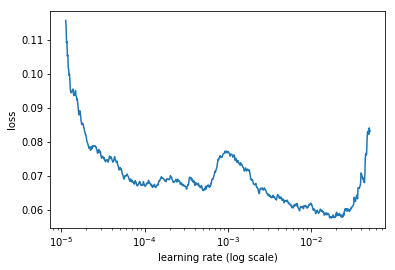

In [38]:
m.sched.plot()

In [39]:
lr = 1e-2

In [42]:
m.fit(lr, 5)

epoch      trn_loss   val_loss                                   
    0      0.027329   0.078485  
    1      0.025443   0.084091                                   
    2      0.024024   0.087418                                   
    3      0.027984   0.082274                                   
    4      0.021692   0.073928                                   



[array([0.07393])]